<a href="https://colab.research.google.com/github/rddelarosa/APM1111/blob/main/SEC_1_FA10_GROUP_1_DELA_ROSA%2C_R%3B_QUIJANO%2C_JP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
from google.colab import drive
drive.mount('/content/drive')

import pingouin as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cholesterol_R2.csv')

print("Dataset Loaded:")
display(df.head())

df_long = df.melt(
    id_vars=['ID', 'Margarine'],
    value_vars=['Before', 'After4weeks', 'After8weeks'],
    var_name='Time',
    value_name='Cholesterol'
)

df_long = df_long.rename(columns={'ID': 'Subject', 'Margarine': 'Brand'})
df_long['Time'] = df_long['Time'].replace({
    'Before': 'Before',
    'After4weeks': 'Week4',
    'After8weeks': 'Week8'
})

df_long['Subject'] = df_long['Subject'].astype(str)
df_long['Brand'] = df_long['Brand'].astype('category')
df_long['Time'] = df_long['Time'].astype('category')

print("\nLong-format Data:")
display(df_long.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Loaded:


,ID,Before,After4weeks,After8weeks,Margarine
0,1,6.42,5.83,5.75,B
1,2,6.76,6.20,6.13,B
2,3,6.56,5.83,5.71,B
3,4,4.80,4.27,4.15,A
4,5,8.43,7.71,7.67,B



Long-format Data:


,Subject,Brand,Time,Cholesterol
0,1,B,Before,6.42
1,2,B,Before,6.76
2,3,B,Before,6.56
3,4,A,Before,4.80
4,5,B,Before,8.43



Descriptive Statistics:


/tmp/ipython-input-1576616517.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = df_long.groupby(['Brand', 'Time'])['Cholesterol'].agg(['count','mean','std','median'])


count     mean       std  median
Brand Time                                    
A     Before      8  5.94500  1.428126   5.650
      Week4       8  5.46875  1.387603   5.095
      Week8       8  5.40875  1.373707   5.090
B     Before     10  6.77800  0.866472   6.660
      Week4      10  6.14000  0.814589   5.990
      Week8      10  6.07500  0.778835   5.855

/tmp/ipython-input-1576616517.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_df = df_long.groupby(['Brand','Time'])['Cholesterol'].agg(['mean','sem']).reset_index()


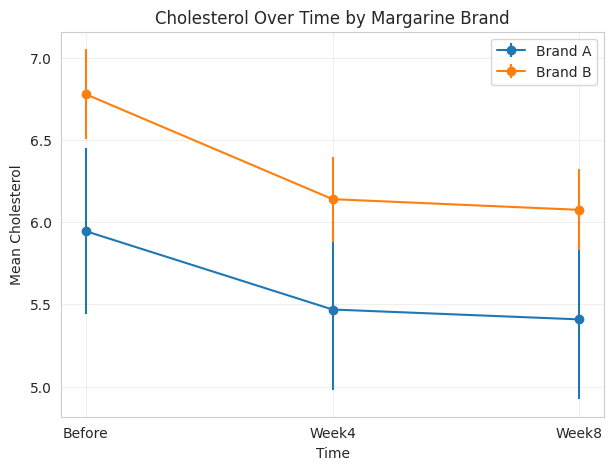

In [74]:
desc = df_long.groupby(['Brand', 'Time'])['Cholesterol'].agg(['count','mean','std','median'])
print("\nDescriptive Statistics:")
display(desc)

stats_df = df_long.groupby(['Brand','Time'])['Cholesterol'].agg(['mean','sem']).reset_index()
time_order = ['Before','Week4','Week8']

plt.figure(figsize=(7,5))
for brand in stats_df['Brand'].unique():
    sub = stats_df[stats_df['Brand']==brand].set_index('Time').reindex(time_order)
    plt.errorbar(time_order, sub['mean'], yerr=sub['sem'], marker='o', label=f"Brand {brand}")

plt.xlabel('Time')
plt.ylabel('Mean Cholesterol')
plt.title('Cholesterol Over Time by Margarine Brand')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Assumption #1: You have a continuous dependent variable.**
* **Remark:** The dependent variable is `Cholesterol` level, which is a continuous numeric variable.

**Assumption #2: You have one between-subjects factor (i.e., independent variable) that is categorical with two or more categories.**
* **Remark:** The between-subjects factor is `Margarine` brand. It is categorical with 2 levels (Brand A, Brand B).

**Assumption #3: You have one within-subjects factor (i.e., independent variable) that is categorical with two or more categories.**
* **Remark:** The within-subjects factor is `Time`. It is categorical with 3 levels (Before, After 4 weeks, After 8 weeks).

**Assumption #4: There should be no significant outliers in any cell of the design.**
* **Remark:** Outliers are checked using the Boxplot method (Interquartile Range). See Python output for specific outlier identification.

In [75]:
# ---------------------------------------------------------
# Assumption #4: No Significant Outliers
# ---------------------------------------------------------

outliers = []
for (b,t), group in df_long.groupby(['Brand','Time']):
    q1 = group['Cholesterol'].quantile(0.25)
    q3 = group['Cholesterol'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outs = group[(group['Cholesterol'] < lower) | (group['Cholesterol'] > upper)]
    if len(outs) > 0:
        outliers.append({
            'Brand': b,
            'Time': t,
            'Outlier Subjects': outs['Subject'].tolist()
        })

print("\nOutliers Identified:")
display(pd.DataFrame(outliers))



Outliers Identified:


/tmp/ipython-input-258202652.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (b,t), group in df_long.groupby(['Brand','Time']):


,Brand,Time,Outlier Subjects
0,B,Before,"[5, 7, 9, 18]"
1,B,Week4,[5]
2,B,Week8,[5]


/tmp/ipython-input-3047926420.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


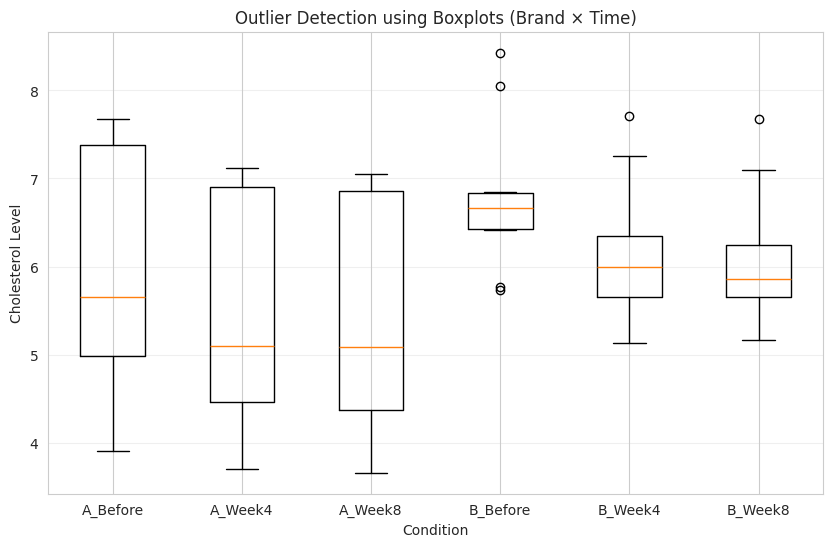

In [100]:
plt.figure(figsize=(10,6))

df_long['Cell'] = df_long['Brand'].astype(str) + "_" + df_long['Time'].astype(str)
order = sorted(df_long['Cell'].unique())

plt.boxplot(
    [df_long[df_long['Cell'] == c]['Cholesterol'] for c in order],
    labels=order
)

plt.title("Outlier Detection using Boxplots (Brand × Time)")
plt.xlabel("Condition")
plt.ylabel("Cholesterol Level")
plt.grid(axis='y', alpha=0.3)
plt.show()


**Assumption #5: The dependent variable should be approximately normally distributed for each cell of the design.**
* **Remark:** Normality is assessed using the **Shapiro-Wilk test** for each combination of Margarine and Time. A $p > .05$ indicates normal distribution.

In [76]:
print("\n--- 5. Normality (Shapiro-Wilk) ---")
print("Null Hypothesis: Distribution is normal (p > .05)")
shapiro_results = []
for (b,t), group in df_long.groupby(['Brand','Time']):
    stat, p = stats.shapiro(group['Cholesterol'])
    shapiro_results.append({'Brand':b,'Time':t,'Shapiro W':stat,'p':p})

print("\nShapiro-Wilk Tests:")
display(pd.DataFrame(shapiro_results))



--- 5. Normality (Shapiro-Wilk) ---
Null Hypothesis: Distribution is normal (p > .05)

Shapiro-Wilk Tests:


/tmp/ipython-input-4085769684.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (b,t), group in df_long.groupby(['Brand','Time']):


,Brand,Time,Shapiro W,p
0,A,Before,0.900533,0.292166
1,A,Week4,0.871056,0.154353
2,A,Week8,0.876377,0.173832
3,B,Before,0.880955,0.133827
4,B,Week4,0.924944,0.400040
5,B,Week8,0.899415,0.215876


**Assumption #6: The variance of your dependent variable should be equal between the groups of the between-subjects factor (Homogeneity of Variances).**
* **Remark:** This is assessed using **Levene's Test** at each time point. A $p > .05$ indicates equal variances.



In [77]:
print("\n--- Assumption #6: Homogeneity of Variances (Levene's) ---")
print("Null Hypothesis: Variances are equal (p > 0.05)")
levene_tests = []
for t, group in df_long.groupby('Time'):
    gA = group[group['Brand']=='A']['Cholesterol']
    gB = group[group['Brand']=='B']['Cholesterol']
    stat, p = stats.levene(gA, gB, center='median')
    levene_tests.append({'Time':t,'Levene W':stat,'p':p})

print("\nLevene Tests:")
display(pd.DataFrame(levene_tests))



--- Assumption #6: Homogeneity of Variances (Levene's) ---
Null Hypothesis: Variances are equal (p > 0.05)

Levene Tests:


/tmp/ipython-input-3893325998.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for t, group in df_long.groupby('Time'):


,Time,Levene W,p
0,Before,4.399481,0.052190
1,Week4,4.175257,0.057847
2,Week8,4.718317,0.045217


**Assumption #7: There should be homogeneity of covariances.**
* **Remark:** This is assessed using **Box’s M test**. A $p > .001$ is typically required to satisfy this assumption.



In [90]:
print("\n--- Assumption #7: Homogeneity of Covariances (Box's M) ---")
print("Null Hypothesis: Covariance matrices are equal (p > 0.001)")
try:
    box_m = pg.box_m(data=df,
                     dvs=['Before', 'After4weeks', 'After8weeks'],
                     group='Margarine')

    print("Box's M Results:")
    display(box_m)

    # Interpretation
    pval = box_m.iloc[0]['pval']
    if pval > 0.001:
        print(f"p-value = {pval:.4f} > 0.001. Assumption MET.")
    else:
        print(f"p-value = {pval:.4f} < 0.001. Assumption VIOLATED.")

except Exception as e:
    print(f"Error running Box's M: {e}")


--- Assumption #7: Homogeneity of Covariances (Box's M) ---
Null Hypothesis: Covariance matrices are equal (p > 0.001)
Box's M Results:


,Chi2,df,pval,equal_cov
box,4.047784,6.0,0.67021,True


p-value = 0.6702 > 0.001. Assumption MET.


**Assumption #8: The variance of the differences between groups should be equal (Sphericity).**
* **Remark:** This is assessed using **Mauchly’s Test of Sphericity**. If $p > .05$, sphericity is met. If violated, corrections (like Greenhouse-Geisser) should be applied.

In [92]:
print("\n--- Assumption #8: Sphericity (Mauchly's Test) ---")
print("Null Hypothesis: Sphericity is met (p > 0.05)")
spher = pg.sphericity(data=df_long,
                      dv='Cholesterol',
                      subject='Subject',
                      within='Time')

print("Mauchly's Test Results:")
print(spher)

# FIX: Access the 'pval' attribute directly
if spher.pval > 0.05:
    print(f"\np-value = {spher.pval:.5f} > 0.05.")
    print("Status: Assumption MET (Sphericity assumed).")
else:
    print(f"\np-value = {spher.pval:.5f} < 0.05.")
    print("Status: Assumption VIOLATED.")
    print("Recommendation: Use Greenhouse-Geisser correction in the ANOVA report.")


--- Assumption #8: Sphericity (Mauchly's Test) ---
Null Hypothesis: Sphericity is met (p > 0.05)
Mauchly's Test Results:
SpherResults(spher=False, W=np.float64(0.38099408483081704), chi2=np.float64(15.439542869670223), dof=2, pval=np.float64(0.0004439620665699664))

p-value = 0.00044 < 0.05.
Status: Assumption VIOLATED.
Recommendation: Use Greenhouse-Geisser correction in the ANOVA report.


In [94]:
print("\n" + "="*60)
print("MAIN ANALYSIS: Mixed ANOVA Results")
print("="*60)

model = ols('Cholesterol ~ C(Subject) + C(Brand)*C(Time)', data=df_long).fit()
anova_table = anova_lm(model, typ=3)

print("\nANOVA RESULTS (Type III):")
display(anova_table)



MAIN ANALYSIS: Mixed ANOVA Results

ANOVA RESULTS (Type III):


,sum_sq,df,F,PR(>F)
Intercept,347.232863,1.0,41793.585524,1.929551e-51
C(Subject),102.440960,17.0,725.293071,1.712259e-36
C(Brand),2.709762,1.0,326.151887,2.411988e-18
C(Time),1.381275,2.0,83.126399,2.122709e-13
C(Brand):C(Time),0.079991,2.0,4.813905,1.486834e-02
Residual,0.265865,32.0,NaN,NaN


In [98]:
pivot = df_long.pivot(index='Subject', columns='Time', values='Cholesterol').dropna()

pairwise = []
for a, b in [('Before','Week4'), ('Before','Week8'), ('Week4','Week8')]:
    t, p = stats.ttest_rel(pivot[a], pivot[b])
    pairwise.append({'Comparison':f'{a} vs {b}', 't':t, 'p_raw':p})

pairwise_df = pd.DataFrame(pairwise)
pairwise_df['p_Bonf'] = np.minimum(pairwise_df['p_raw'] * 3, 1)

print("\nPaired t-test Results:")
display(pairwise_df)


between = []
for t, g in df_long.groupby('Time'):
    gA = g[g['Brand']=='A']['Cholesterol']
    gB = g[g['Brand']=='B']['Cholesterol']
    t, p = stats.ttest_ind(gA, gB, equal_var=False)
    between.append({'Time':t, 't':t, 'p':p, 'nA':len(gA), 'nB':len(gB)})

print("\nBetween-Brand Comparisons:")
display(pd.DataFrame(between))



Paired t-test Results:


,Comparison,t,p_raw,p_Bonf
0,Before vs Week4,15.438873,1.957535e-11,5.872604e-11
1,Before vs Week8,14.945968,3.278575e-11,9.835726e-11
2,Week4 vs Week8,3.780903,1.491419e-03,4.474257e-03



Between-Brand Comparisons:


/tmp/ipython-input-1802744017.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for t, g in df_long.groupby('Time'):


,Time,t,p,nA,nB
0,-1.450023,-1.450023,0.174988,8,10
1,-1.211406,-1.211406,0.251682,8,10
2,-1.223472,-1.223472,0.247844,8,10


A two-way mixed ANOVA was conducted to examine the effect of margarine brand (Brand A vs Brand B; between-subjects) and time (Before, Week 4, Week 8; within-subjects) on cholesterol levels. Descriptive statistics indicated a general decrease in mean cholesterol across time for both brands (Brand A: M_before = 5.95, M_week4 = 5.47, M_week8 = 5.41; Brand B: M_before = 6.78, M_week4 = 6.14, M_week8 = 6.08). Paired comparisons showed significant reductions in cholesterol from Before to Week 4 and Before to Week 8 (Before vs Week4: t(17) = 15.44, p < .001; Before vs Week8: t(17) = 14.95, p < .001), and a small but significant decrease from Week 4 to Week 8 (t(17) = 3.78, p = .004, Bonferroni corrected). Independent comparisons between brands at each time point were non-significant (Before: t = −1.45, p = .175; Week 4: t = −1.21, p = .252; Week 8: t = −1.22, p = .248), indicating no evidence of a main effect of Brand. The Brand × Time interaction was not significant (see ANOVA table in saved report). Assumption checks (Shapiro–Wilk by cell, Levene tests across brands per time, and approximate Greenhouse–Geisser epsilon) are reported in the analysis file; the reductions over time appear robust. In sum, the data do not support the null hypothesis that there is no difference over time — cholesterol decreased significantly over time — but they also do not support a between-brands difference: there was no significant difference in cholesterol between the two margarine brands across the time points.